In [1]:
import numpy as np
import pandas as pd
import pylab as plt
from scipy import linalg
from scipy.sparse import bsr_array
from matplotlib.transforms import ScaledTranslation

from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.metrics.pairwise import rbf_kernel

# Working in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def pcg(A, b, M=None, epsilon=1e-5):
    """
    Preconditioned Conjugate Gradient method to solve Ax = b.
    Source: https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf

    Parameters:
    - A: (n x n) numpy array, the matrix of the linear system.
    - b: (n,) numpy array, the right-hand side vector.
    - M: (n x n) numpy array or None, the preconditioner matrix (optional).
         If None, uses the identity matrix.
    - epsilon: float, the tolerance for the stopping criterion.

    Returns:
    - x: (n,) numpy array, the approximate solution.
    - num_iter: int, the number of iterations performed.
    """
    n = len(b)
    max_iter = n * 10  # Maximum number of iterations
    e_tol = epsilon * np.linalg.norm(b)  # Error tolerance (as used by scipy)

    # Use the identity matrix as the default preconditioner if M is not provided
    M = np.eye(n) if M is None else M

    # Shewchuck reccomends to recompute the residual exactly
    # after 50 or root(N) for large datasets
    i_recompute = max(50, int(n ** 0.5))
    residuals = np.zeros(max_iter)

    # Initial guess x = 0 and initial residual r = b
    x = np.zeros(n)
    r = b.copy()
    d = M @ r
    delta_new = r.T @ d

    for i in range(max_iter):
        norm_r = linalg.norm(r)
        residuals[i] = norm_r

        if norm_r < e_tol:
            return x, i, residuals[:i]

        q = A @ d
        alpha = delta_new / (d.T @ q)
        x = x + alpha * d

        if i % i_recompute == 0:
            r = b - A @ x
        else:
            r = r - alpha * q

        s = M @ r
        delta_old = delta_new
        delta_new = r.T @ s
        beta = delta_new / delta_old
        d = s + beta * d

    return x, max_iter, residuals


def no_preconditioner(A, b, s, kernel, mu=1e-5, epsilon=1e-5):
    """
    Vanilla Conjugate Gradient preconditioner for KRR.

    Parameters:
    - A: (n x n) numpy array, the kernel matrix.
    - b: (n,) numpy array, the right-hand side vector.
    - s: (k,) numpy array, the centers (e.g., uniformly sampled indices).
    - mu: float, regularization parameter.
    - epsilon: float, the tolerance for the stopping criterion.

    Returns:
    - A, b, M: inputs to PGC
    """
    n = len(b)
    k = len(s)
    H = mu * A[:, s] + n * epsilon * np.trace(A[:, s]) * np.eye(k)
    product = A @ A.T + H

    return product, A @ b, np.eye(k)


def krill_preconditioner(A, b, s, kernel, mu=1e-5, epsilon=1e-5):
    """
    Krill Preconditioned Conjugate Gradient preconditioner for KRR.
    Source: https://arxiv.org/pdf/2304.12465

    Parameters:
    - A: (n x n) numpy array, the kernel matrix.
    - b: (n,) numpy array, the right-hand side vector.
    - s: (k,) numpy array, the centers (e.g., uniformly sampled indices).
    - mu: float, regularization parameter.
    - epsilon: float, the tolerance for the stopping criterion.

    Returns:
    - A, b, M: inputs to PGC
    """
    n = len(b)
    k = len(s)

    H = mu * A[:, s] + n * epsilon * np.trace(A[:, s]) * np.eye(k)
    E = sparse_sign_embedding(2 * k, n, min(8, 2 * k))
    B = E @ A.T
    P = B.T @ B + H
    C = linalg.cholesky(P + epsilon * np.trace(P) * np.eye(k))
    C_inv = linalg.inv(C)

    # Solve the system using the PCG method
    product = A @ A.T + H
    return (product, A @ b, C_inv @ C_inv.T)


def sparse_sign_embedding(d, n, gamma):
    """
    Generate a sparse sign embedding matrix.
    Source: https://arxiv.org/pdf/2304.12465

    Parameters:
    - d: int, the number of rows in the embedding matrix.
    - n: int, the number of columns in the embedding matrix.
    - gamma: int, the sparsity parameter (number of non-zero entries per column).

    Returns:
    - E: (d x n) sparse BSR matrix.
    """
    rows = np.zeros(n * gamma, dtype=int)
    cols = np.zeros(n * gamma, dtype=int)
    vals = np.zeros(n * gamma)

    for j in range(n):
        indices = np.random.choice(d, gamma, replace=False)
        signs = np.random.choice([-1, 1], gamma)
        rows[j * gamma:(j + 1) * gamma] = indices
        cols[j * gamma:(j + 1) * gamma] = j
        vals[j * gamma:(j + 1) * gamma] = signs * gamma ** (-0.5)

    return bsr_array((vals, (rows, cols)), shape=(d, n))

In [ ]:
class PCG():
    def __init__(self, kernel, preconditioner):
        self.kernel = kernel
        self.preconditioner = preconditioner


    def train(self, X, y, n_centers=None, mu=1e-6, epsilon=1e-6):

        self.X = X
        n = len(y)

        # If no centers given use all data
        n_centers = n if n_centers == None else n_centers
        # Sample centers uniformly at random
        self.s = np.random.choice(n, n_centers, replace=False)

        # Compute Kernel matrix
        K = self.kernel(self.X[self.s, :], X)
        # Precondition
        self.A, self.b, self.M = self.preconditioner(K, y, self.s, self.kernel, mu=mu, epsilon=epsilon)
        self.w, self.i, self.r = pcg(self.A, self.b, self.M, epsilon=epsilon)

        if self.i < len(self.s):
            print(f"Converged in {self.i} interations")
        else:
            print(f"Convergence failed after {self.i} interations")


    def predict(self, test):
        K = self.kernel(self.X[self.s, :], test)

        return self.w @ K

In [2]:
# Data avalible here: https://archive.ics.uci.edu/dataset/882/large-scale+wave+energy+farm
sydney_49 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/WEC_Sydney_49.csv')
X = sydney_49.filter(regex=r'(Y|X)', axis=1).to_numpy()
y = sydney_49['Total_Power'].to_numpy() / 10**6

In [ ]:
%%timeit
cg = PCG(rbf_kernel, no_preconditioner)
cg.train(X, y, n_centers=1000, mu=1e-4, epsilon=1e-10)


Converged in 477 interations
Converged in 580 interations
Converged in 565 interations
Converged in 624 interations
Converged in 335 interations
Converged in 437 interations
Converged in 303 interations
Converged in 439 interations
1.95 s ± 672 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
krill_cg = PCG(rbf_kernel, krill_preconditioner)
krill_cg.train(X, y, n_centers=1000, mu=1e-4, epsilon=1e-10)


Converged in 42 interations
Converged in 43 interations
Converged in 43 interations
Converged in 42 interations
Converged in 43 interations
Converged in 42 interations
Converged in 43 interations
Converged in 45 interations
3.72 s ± 514 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
cg_eig = np.absolute(linalg.eig(cg.A)[0])
cg_eig.sort()

krill_eig = np.absolute(linalg.eig(krill_cg.M @ krill_cg.A)[0])
krill_eig.sort()

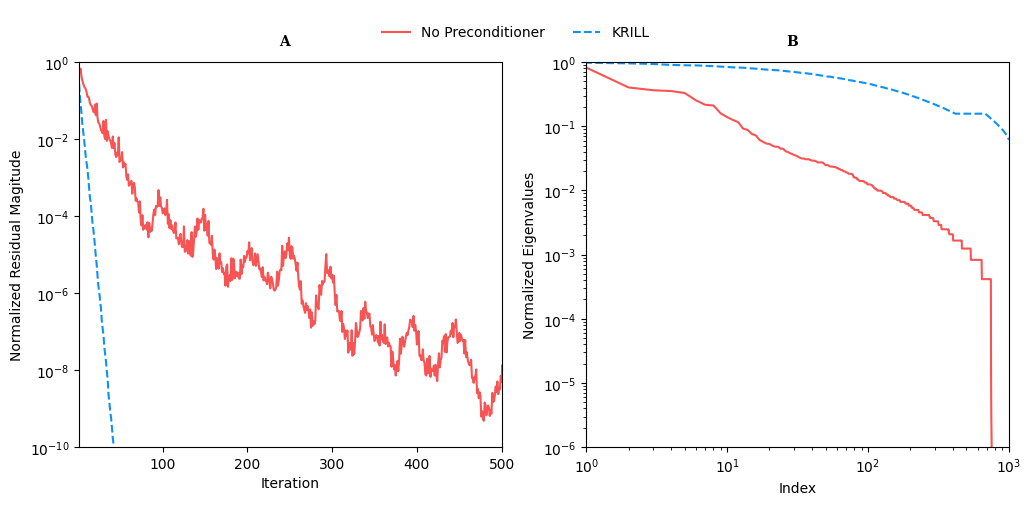

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of residuals
ax1.plot(cg.r / cg.r[0], color='#F95454', label='No Preconditioner')
ax1.plot(krill_cg.r / krill_cg.r[0], color='#0D92F4', ls='dashed', label='KRILL')

# Formating
ax1.set_yscale('log')
ax1.set_xlim(1, 500)
ax1.set_ylim(1e-10, 1)
ax1.set_ylabel('Normalized Residual Magitude')
ax1.set_xlabel('Iteration')

# Plot of eigenvalues
ax2.plot(krill_eig[::-1]/krill_eig[-1], color='#0D92F4', ls='dashed')
ax2.plot(cg_eig[::-1]/cg_eig[-1], color='#F95454')
# Formatting
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlim(1, 10**3)
ax2.set_ylim(1e-6, 1)
ax2.set_ylabel('Normalized Eigenvalues')
ax2.set_xlabel('Index')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncols=2, borderpad=1.4, fancybox=False, facecolor='None', edgecolor='None')

# Labels
for label, ax in zip(['A', 'B'], (ax1, ax2)):
    ax.text(
        0.54, 1.01, label, transform=(
            ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='medium', weight='bold', va='bottom', fontfamily='serif')

plt.savefig('Figure1.png', dpi=400)